# Example notebook for Catboost

## Notebook configuration

In [ ]:
# Load some libraries
import os 
import sys
import pandas as pd
import numpy as np

# Set up system path, and import our custom modules
sys.path.append(os.path.abspath(os.path.join("..", "..", "src")))
from helpers import add_cell_timer
from pipeline.catboost import CatBoostPipeline
add_cell_timer()

data_file = "../../data/subset_transactions2.csv"

## Load and preprocess data

In [55]:
pl = CatBoostPipeline(data_file)
pl.rename_columns()
pl.drop_duplicates()
pl.check_for_null()
pl.extract_currency_features()
pl.extract_time_features()
pl.create_unique_ids()
#pl.extract_additional_time_features()
pl.cyclical_encoding()
pl.apply_one_hot_encoding()

c:\Users\sophi\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
c:\Users\sophi\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


## Split data into train/val/test, and continue with split-specific feature engineering
There are some features that, if engineered or standardized using the whole dataset, could result in data leakage between our train/val/test sets. Therefore, we must split the data prior to these calculations. 
For CatBoost, we will use a temporal split.

In [56]:
print(pl.df.columns)

Index(['from_bank', 'to_bank', 'received_amount', 'sent_amount',
       'is_laundering', 'log_exchange_rate', 'sent_amount_usd', 'is_weekend',
       'timestamp_int', 'edge_id', 'from_account_idx', 'to_account_idx',
       'day_cos', 'day_sin', 'time_of_day_cos', 'time_of_day_sin',
       'received_currency_Australian Dollar', 'received_currency_Bitcoin',
       'received_currency_Brazil Real', 'received_currency_Canadian Dollar',
       'received_currency_Euro', 'received_currency_Mexican Peso',
       'received_currency_Ruble', 'received_currency_Rupee',
       'received_currency_Saudi Riyal', 'received_currency_Shekel',
       'received_currency_Swiss Franc', 'received_currency_UK Pound',
       'received_currency_US Dollar', 'received_currency_Yen',
       'received_currency_Yuan', 'sent_currency_Australian Dollar',
       'sent_currency_Bitcoin', 'sent_currency_Brazil Real',
       'sent_currency_Canadian Dollar', 'sent_currency_Euro',
       'sent_currency_Mexican Peso', 'sent_cu

In [57]:
edge_feats = list(set(pl.df.columns)-set(['hour_of_day','is_weekend','sent_amount','received_amount']))

# Temporal split for edges
pl.split_train_test_val(X_cols=edge_feats, test_size=0.2, val_size=0.2) # default is temporal split, keeps account_idx's for node feature mapping

Keeping from_account_idx and to_account_idx (for merging node feats onto tabular data for Catboost)


In [59]:
print(pl.X_cols)

['time_of_day_sin', 'received_currency_Rupee', 'sent_currency_Yen', 'to_account_idx', 'received_currency_Bitcoin', 'payment_type_Cash', 'sent_currency_Euro', 'log_exchange_rate', 'received_currency_Brazil Real', 'sent_currency_Australian Dollar', 'day_sin', 'sent_currency_Swiss Franc', 'sent_currency_Ruble', 'received_currency_Yen', 'sent_currency_Rupee', 'received_currency_Ruble', 'sent_currency_US Dollar', 'sent_currency_Saudi Riyal', 'payment_type_Wire', 'sent_currency_Brazil Real', 'sent_currency_UK Pound', 'sent_currency_Bitcoin', 'timestamp_int', 'sent_currency_Shekel', 'sent_currency_Yuan', 'received_currency_Swiss Franc', 'payment_type_Cheque', 'sent_currency_Mexican Peso', 'payment_type_Credit Card', 'edge_id', 'received_currency_Canadian Dollar', 'received_currency_Saudi Riyal', 'payment_type_ACH', 'from_account_idx', 'received_currency_Yuan', 'received_currency_US Dollar', 'sent_amount_usd', 'time_of_day_cos', 'received_currency_UK Pound', 'received_currency_Australian Dolla

In [60]:
# Scale edge features
pl.numerical_scaling(numerical_features=['timestamp_int','sent_amount_usd'])

In [62]:
drop = ['from_account_idx', 'to_account_idx', 'edge_id']
init_feats = [col for col in pl.X_cols if col not in drop]

In [63]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score
)
X_train_sub = pl.X_train[init_feats]
X_val_sub = pl.X_val[init_feats]
X_test_sub = pl.X_test[init_feats]

# 1) Adjust XGBClassifier to reduce overfitting:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=20,  # more patience
    max_depth=4,               # shallower trees generalize better
    learning_rate=0.05,        # lower for smoother learning
    subsample=0.8,             # row sampling (bagging)
    colsample_bytree=0.8,      # feature sampling
    min_child_weight=5,        # prevents learning from small splits
    gamma=1,                   # adds regularization
    reg_alpha=1,               # L1 regularization
    reg_lambda=1,              # L2 regularization
    objective='binary:logistic',
    scale_pos_weight=12,       # keep this if your positive class is rare
    eval_metric='aucpr',
    random_state=42,
    verbosity=1
)

# 2) Train model with early stopping:
xgb_model.fit(
    X_train_sub, pl.y_train,
    eval_set=[(X_val_sub, pl.y_val)],
    verbose=100
)

# 3) Get predicted probabilities:
train_proba = xgb_model.predict_proba(X_train_sub)[:, 1]
val_proba   = xgb_model.predict_proba(X_val_sub)[:, 1]
test_proba  = xgb_model.predict_proba(X_test_sub)[:, 1]

# 4) Apply 0.5 threshold for binary predictions:
train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

# 5) Evaluate results:
print(f"Train  PR-AUC: {average_precision_score(pl.y_train, train_proba):.4f}")
print(f"Valid  PR-AUC: {average_precision_score(pl.y_val,   val_proba):.4f}")
print(f"Test   PR-AUC: {average_precision_score(pl.y_test,  test_proba):.4f}")
print("\nTest Classification Report:")
print(classification_report(pl.y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(pl.y_test, test_proba):.4f}")

[0]	validation_0-aucpr:0.03883
[100]	validation_0-aucpr:0.14106
[113]	validation_0-aucpr:0.14222
Train  PR-AUC: 0.1183
Valid  PR-AUC: 0.1453
Test   PR-AUC: 0.2831

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    248420
           1       0.37      0.31      0.34      1761

    accuracy                           0.99    250181
   macro avg       0.68      0.65      0.67    250181
weighted avg       0.99      0.99      0.99    250181

Test ROC-AUC: 0.9433


### Create node features
Node features are specific to accounts, and include graph based features like pagerank and degree centrality, as well as some aggregate statistics such as net flow (total amount sent-total amount received for a specific account). 

In [9]:
# Compute node features split-specifically
pl.compute_split_specific_node_features()

# Scale only relevant node features (others like pagerank left raw)
pl.scale_node_data_frames()

✅ Computed node features for train with 106913 nodes.
✅ Computed node features for val with 107240 nodes.
✅ Computed node features for test with 107583 nodes.


In [11]:
print(pl.train_nodes.columns) # peek at cols

Index(['node_id', 'degree_centrality', 'pagerank', 'net_flow', 'avg_txn_out',
       'avg_txn_in', 'std_txn_out', 'std_txn_in', 'num_unique_out_partners',
       'num_unique_in_partners'],
      dtype='object')


### Add node features to df
With CatBoost, we are working with tbaular transaction data, so need to merge out node-level stats onto this. 

In [12]:
pl.X_train.columns

Index(['time_of_day_sin', 'received_currency_Rupee', 'sent_currency_Yen',
       'to_account_idx', 'received_currency_Bitcoin', 'payment_type_Cash',
       'sent_currency_Euro', 'log_exchange_rate',
       'received_currency_Brazil Real', 'sent_currency_Australian Dollar',
       'day_sin', 'sent_currency_Swiss Franc', 'sent_currency_Ruble',
       'received_currency_Yen', 'sent_currency_Rupee',
       'received_currency_Ruble', 'sent_currency_US Dollar',
       'sent_currency_Saudi Riyal', 'payment_type_Wire',
       'sent_currency_Brazil Real', 'sent_currency_UK Pound',
       'sent_currency_Bitcoin', 'timestamp_int', 'sent_currency_Shekel',
       'time_diff_to', 'sent_currency_Yuan', 'received_currency_Swiss Franc',
       'payment_type_Cheque', 'sent_currency_Mexican Peso',
       'payment_type_Credit Card', 'edge_id',
       'received_currency_Canadian Dollar', 'received_currency_Saudi Riyal',
       'payment_type_ACH', 'from_account_idx', 'received_currency_Yuan',
       'turnar

In [13]:
pl.add_node_graph_feats_to_df()

In [14]:
pl.X_train.columns

Index(['time_of_day_sin', 'received_currency_Rupee', 'sent_currency_Yen',
       'received_currency_Bitcoin', 'payment_type_Cash', 'sent_currency_Euro',
       'log_exchange_rate', 'received_currency_Brazil Real',
       'sent_currency_Australian Dollar', 'day_sin',
       'sent_currency_Swiss Franc', 'sent_currency_Ruble',
       'received_currency_Yen', 'sent_currency_Rupee',
       'received_currency_Ruble', 'sent_currency_US Dollar',
       'sent_currency_Saudi Riyal', 'payment_type_Wire',
       'sent_currency_Brazil Real', 'sent_currency_UK Pound',
       'sent_currency_Bitcoin', 'timestamp_int', 'sent_currency_Shekel',
       'time_diff_to', 'sent_currency_Yuan', 'received_currency_Swiss Franc',
       'payment_type_Cheque', 'sent_currency_Mexican Peso',
       'payment_type_Credit Card', 'edge_id',
       'received_currency_Canadian Dollar', 'received_currency_Saudi Riyal',
       'payment_type_ACH', 'received_currency_Yuan', 'turnaround_time',
       'sent_amount_usd', 'time_o

need to drop timestamp_int and edge_id before running catboost

In [15]:
# Scale edge features
pl.numerical_scaling(numerical_features=['timestamp_int','sent_amount_usd','time_diff_from','time_diff_to', 'turnaround_time'])

In [16]:
drop='edge_id'
pl.X_train.drop(drop, axis=1, inplace=True)
pl.X_val.drop(drop, axis=1, inplace=True)
pl.X_test.drop(drop, axis=1, inplace=True)

In [17]:
pl.X_train.columns

Index(['time_of_day_sin', 'received_currency_Rupee', 'sent_currency_Yen',
       'received_currency_Bitcoin', 'payment_type_Cash', 'sent_currency_Euro',
       'log_exchange_rate', 'received_currency_Brazil Real',
       'sent_currency_Australian Dollar', 'day_sin',
       'sent_currency_Swiss Franc', 'sent_currency_Ruble',
       'received_currency_Yen', 'sent_currency_Rupee',
       'received_currency_Ruble', 'sent_currency_US Dollar',
       'sent_currency_Saudi Riyal', 'payment_type_Wire',
       'sent_currency_Brazil Real', 'sent_currency_UK Pound',
       'sent_currency_Bitcoin', 'timestamp_int', 'sent_currency_Shekel',
       'time_diff_to', 'sent_currency_Yuan', 'received_currency_Swiss Franc',
       'payment_type_Cheque', 'sent_currency_Mexican Peso',
       'payment_type_Credit Card', 'received_currency_Canadian Dollar',
       'received_currency_Saudi Riyal', 'payment_type_ACH',
       'received_currency_Yuan', 'turnaround_time', 'sent_amount_usd',
       'time_of_day_cos',

# Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score
)

# 1) Adjust XGBClassifier to reduce overfitting:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=20,  # more patience
    max_depth=4,               # shallower trees generalize better
    learning_rate=0.05,        # lower for smoother learning
    subsample=0.8,             # row sampling (bagging)
    colsample_bytree=0.8,      # feature sampling
    min_child_weight=5,        # prevents learning from small splits
    gamma=1,                   # adds regularization
    reg_alpha=1,               # L1 regularization
    reg_lambda=1,              # L2 regularization
    objective='binary:logistic',
    scale_pos_weight=12,       # keep this if your positive class is rare
    eval_metric='aucpr',
    random_state=42,
    verbosity=1
)

# 2) Train model with early stopping:
xgb_model.fit(
    pl.X_train, pl.y_train,
    eval_set=[(pl.X_val, pl.y_val)],
    verbose=100
)

# 3) Get predicted probabilities:
train_proba = xgb_model.predict_proba(pl.X_train)[:, 1]
val_proba   = xgb_model.predict_proba(pl.X_val)[:, 1]
test_proba  = xgb_model.predict_proba(pl.X_test)[:, 1]

# 4) Apply 0.5 threshold for binary predictions:
train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

# 5) Evaluate results:
print(f"Train  PR-AUC: {average_precision_score(pl.y_train, train_proba):.4f}")
print(f"Valid  PR-AUC: {average_precision_score(pl.y_val,   val_proba):.4f}")
print(f"Test   PR-AUC: {average_precision_score(pl.y_test,  test_proba):.4f}")
print("\nTest Classification Report:")
print(classification_report(pl.y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(pl.y_test, test_proba):.4f}")

[0]	validation_0-aucpr:0.10939
[100]	validation_0-aucpr:0.54014
[200]	validation_0-aucpr:0.59301
[300]	validation_0-aucpr:0.61767
[400]	validation_0-aucpr:0.62732
[499]	validation_0-aucpr:0.63325
Train  PR-AUC: 0.6735
Valid  PR-AUC: 0.6334
Test   PR-AUC: 0.7323

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    248420
           1       0.50      0.78      0.60      1761

    accuracy                           0.99    250181
   macro avg       0.75      0.88      0.80    250181
weighted avg       0.99      0.99      0.99    250181

Test ROC-AUC: 0.9891


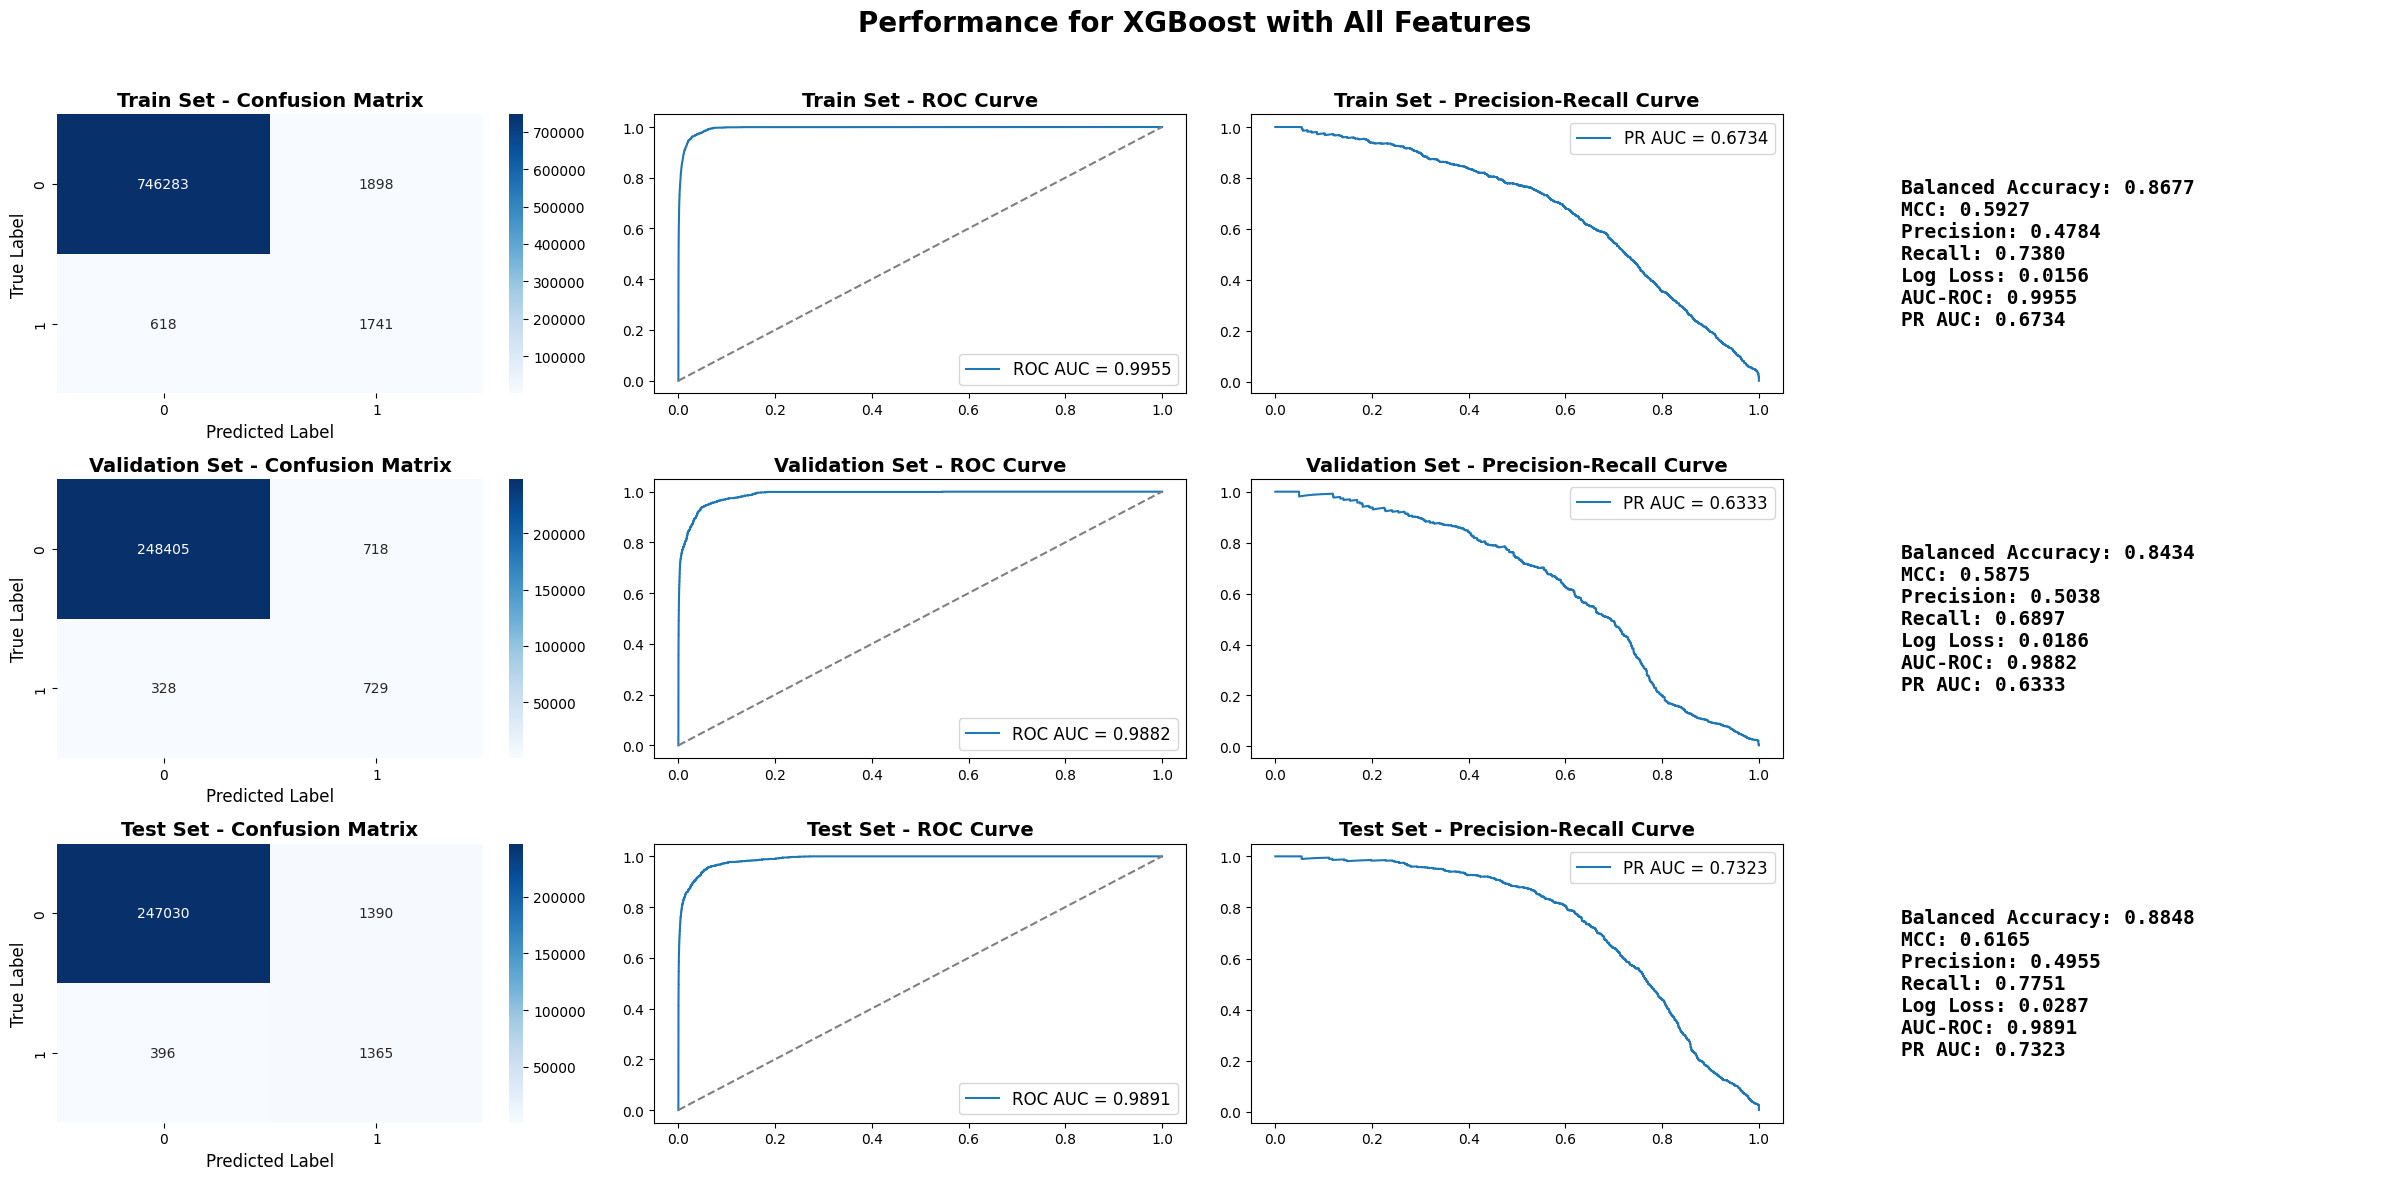

In [20]:
from plotting.result_metrics import result_metrics
# 6) Finally, re-use your 3×4 plotting helper:
slide_title = "Performance for XGBoost with All Features"
result_metrics(
    slide_title,
    pl.y_train, train_pred, train_proba,
    pl.y_val,   val_pred,   val_proba,
    pl.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)

### Rank feature importance

In [23]:
import shap
import numpy as np
import pandas as pd

# 1. Create a SHAP explainer for your fitted XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 2. Compute SHAP values for your test set (matrix of shape [n_samples, n_features])
shap_values = explainer.shap_values(pl.X_test)

# 3. Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 4. Build a ranking DataFrame
shap_importance = pd.DataFrame({
    'feature': pl.X_test.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print(shap_importance)

                       feature  mean_abs_shap
0             payment_type_ACH       1.604343
1       from_degree_centrality       0.730804
2               time_diff_from       0.683064
3              sent_amount_usd       0.488136
4             from_avg_txn_out       0.369287
..                         ...            ...
60   sent_currency_Swiss Franc       0.000131
61  received_currency_UK Pound       0.000053
62           payment_type_Wire       0.000000
63     received_currency_Rupee       0.000000
64           sent_currency_Yen       0.000000

[65 rows x 2 columns]


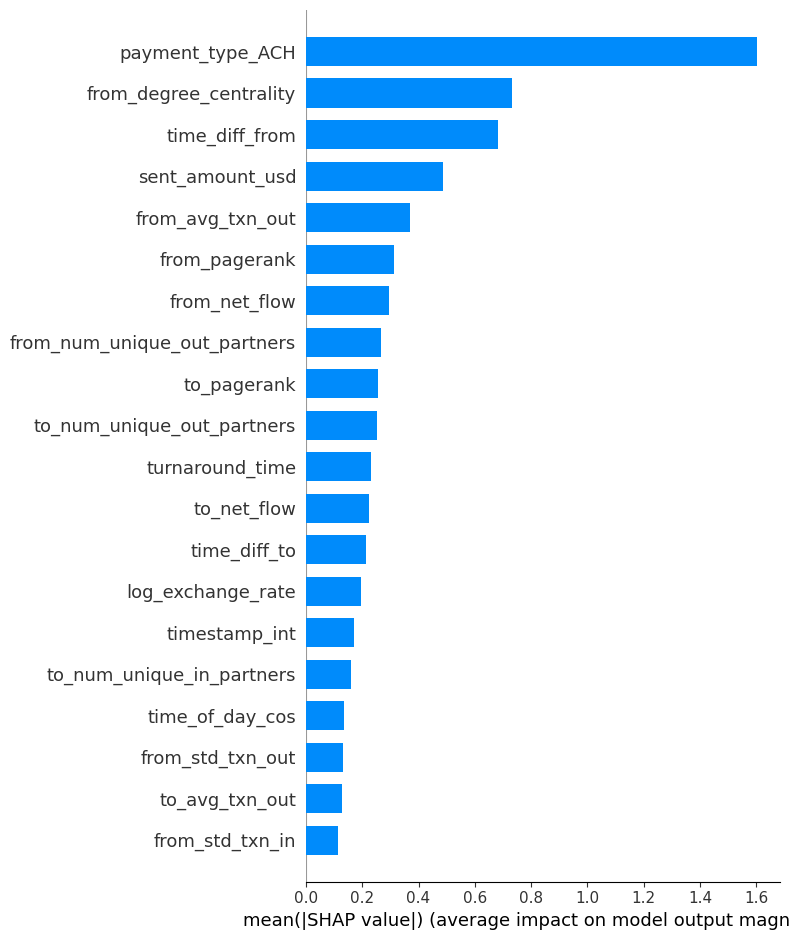

In [25]:
shap.summary_plot(
    shap_values,
    pl.X_test,
    plot_type='bar',
    max_display=20  # show top 20 features
)

In [26]:
X = pd.concat([pl.X_train, pl.X_val, pl.X_test], axis=0, ignore_index=True)
# 2) Define your groups of interest
currency_features_sent     = [c for c in X.columns if c.startswith("sent_currency_")]
currency_features_received = [c for c in X.columns if c.startswith("received_currency_")]
payment_type_features      = [c for c in X.columns if c.startswith("payment_type_")]

# 3) Pull out top-3 in each
top3_sent     = (shap_importance[shap_importance['feature'].isin(currency_features_sent)]
                 .nlargest(3, 'mean_abs_shap'))
top3_received = (shap_importance[shap_importance['feature'].isin(currency_features_received)]
                 .nlargest(3, 'mean_abs_shap'))
top3_payment  = (shap_importance[shap_importance['feature'].isin(payment_type_features)]
                 .nlargest(3, 'mean_abs_shap'))

print("▶ Top 3 ‘currencies sent’ by |SHAP|:")
print(top3_sent.to_string(index=False))

print("\n▶ Top 3 ‘currencies received’ by |SHAP|:")
print(top3_received.to_string(index=False))

print("\n▶ Top 3 ‘payment types’ by |SHAP|:")
print(top3_payment.to_string(index=False))

▶ Top 3 ‘currencies sent’ by |SHAP|:
                  feature  mean_abs_shap
       sent_currency_Euro       0.028507
sent_currency_Saudi Riyal       0.019752
    sent_currency_Bitcoin       0.010421

▶ Top 3 ‘currencies received’ by |SHAP|:
                      feature  mean_abs_shap
     received_currency_Shekel       0.015393
received_currency_Saudi Riyal       0.006335
received_currency_Swiss Franc       0.006160

▶ Top 3 ‘payment types’ by |SHAP|:
                 feature  mean_abs_shap
        payment_type_ACH       1.604343
payment_type_Credit Card       0.105353
    payment_type_Bitcoin       0.047593


In [27]:
X_train, X_val, X_test = pl.X_train.copy(), pl.X_val.copy(), pl.X_test.copy()

In [28]:
X_train['sent_currency_other'] = (pl.X_train[currency_features_sent].sum(axis=1) - pl.X_train[top3_sent].sum(axis=1) > 0).astype(int)
X_train['received_currency_other'] = (pl.X_train[currency_features_received].sum(axis=1) - pl.X_train[top3_received].sum(axis=1) > 0).astype(int)
X_train['payment_type_other'] = (pl.X_train[payment_type_features].sum(axis=1) - pl.X_train[top3_payment].sum(axis=1) > 0).astype(int)

X_val['sent_currency_other'] = (pl.X_val[currency_features_sent].sum(axis=1) - pl.X_val[top3_sent].sum(axis=1) > 0).astype(int)
X_val['received_currency_other'] = (pl.X_val[currency_features_received].sum(axis=1) - pl.X_val[top3_received].sum(axis=1) > 0).astype(int)
X_val['payment_type_other'] = (pl.X_val[payment_type_features].sum(axis=1) - pl.X_val[top3_payment].sum(axis=1) > 0).astype(int)

X_test['sent_currency_other'] = (pl.X_test[currency_features_sent].sum(axis=1) - pl.X_test[top3_sent].sum(axis=1) > 0).astype(int)
X_test['received_currency_other'] = (pl.X_test[currency_features_received].sum(axis=1) - pl.X_test[top3_received].sum(axis=1) > 0).astype(int)
X_test['payment_type_other'] = (pl.X_test[payment_type_features].sum(axis=1) - pl.X_test[top3_payment].sum(axis=1) > 0).astype(int)

In [29]:
X_train.columns

Index(['time_of_day_sin', 'received_currency_Rupee', 'sent_currency_Yen',
       'received_currency_Bitcoin', 'payment_type_Cash', 'sent_currency_Euro',
       'log_exchange_rate', 'received_currency_Brazil Real',
       'sent_currency_Australian Dollar', 'day_sin',
       'sent_currency_Swiss Franc', 'sent_currency_Ruble',
       'received_currency_Yen', 'sent_currency_Rupee',
       'received_currency_Ruble', 'sent_currency_US Dollar',
       'sent_currency_Saudi Riyal', 'payment_type_Wire',
       'sent_currency_Brazil Real', 'sent_currency_UK Pound',
       'sent_currency_Bitcoin', 'timestamp_int', 'sent_currency_Shekel',
       'time_diff_to', 'sent_currency_Yuan', 'received_currency_Swiss Franc',
       'payment_type_Cheque', 'sent_currency_Mexican Peso',
       'payment_type_Credit Card', 'received_currency_Canadian Dollar',
       'received_currency_Saudi Riyal', 'payment_type_ACH',
       'received_currency_Yuan', 'turnaround_time', 'sent_amount_usd',
       'time_of_day_cos',

In [30]:
top3_sent  = top3_sent['feature'].tolist()
top3_received = top3_received['feature'].tolist()
top3_payment  = top3_payment['feature'].tolist()

In [33]:
from sklearn.metrics import f1_score, average_precision_score

# 2) Make everything a Python list before concatenating
all_cols = X_train.columns.tolist()

# 3) Build grouped_onehot as a set of strings
grouped_onehot = set(currency_features_sent
                     + currency_features_received
                     + payment_type_features)

# 4) Now safely slice it out
base_features = [c for c in all_cols if c not in grouped_onehot]

# 6) Define your feature_sets
feature_sets = {
    "all_onehots":        base_features + currency_features_sent   + currency_features_received + payment_type_features,
    "no_sent":            base_features + currency_features_received + payment_type_features,
    "no_received":        base_features + currency_features_sent     + payment_type_features,
    "no_currency":        base_features + payment_type_features,
    "top3_all":           base_features + top3_sent  + top3_received + top3_payment,
    "top3_payment_only":  base_features + currency_features_sent  + currency_features_received + top3_payment,
    #"top1_payment_only":  base_features + currency_features_sent + currency_features_received + ['payment_type_ACH','payment_type_other'],
}

def evaluate_feature_sets_xgb(X_train, y_train,
                              X_val, y_val, feature_sets):
    results = {}
    for name, feats in feature_sets.items():
        X_train_sub = X_train[feats].astype(np.float32).values
        X_val_sub   = X_val[feats].astype(np.float32).values

        model = xgb.XGBClassifier(
            n_estimators=500,
            early_stopping_rounds=20,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=5,
            gamma=1,
            reg_alpha=1,
            reg_lambda=1,
            objective='binary:logistic',
            scale_pos_weight=12,
            eval_metric='aucpr',
            random_state=42,
            verbosity=0
        )

        model.fit(
            X_train_sub, y_train,
            eval_set=[(X_val_sub, y_val)],
            verbose=100
        )

        y_pred = model.predict(X_val_sub)
        y_prob = model.predict_proba(X_val_sub)[:, 1]

        f1 = f1_score(y_val, y_pred)
        pr_auc = average_precision_score(y_val, y_prob)

        results[name] = {"F1": f1, "PR AUC": pr_auc}
        print(f"{name:20s} →  F1 = {f1:.4f},  PR-AUC = {pr_auc:.4f}")

    return results

# Call the function:
results = evaluate_feature_sets_xgb(
    X_train, pl.y_train,
    X_val,   pl.y_val,
    feature_sets
)

[0]	validation_0-aucpr:0.10111
[100]	validation_0-aucpr:0.54207
[200]	validation_0-aucpr:0.59075
[300]	validation_0-aucpr:0.61440
[400]	validation_0-aucpr:0.62679
[444]	validation_0-aucpr:0.62903
all_onehots          →  F1 = 0.5776,  PR-AUC = 0.6304
[0]	validation_0-aucpr:0.09442
[100]	validation_0-aucpr:0.52925
[200]	validation_0-aucpr:0.58695
[300]	validation_0-aucpr:0.61050
[400]	validation_0-aucpr:0.62178
[499]	validation_0-aucpr:0.62732
no_sent              →  F1 = 0.5686,  PR-AUC = 0.6274
[0]	validation_0-aucpr:0.09442
[100]	validation_0-aucpr:0.52901
[200]	validation_0-aucpr:0.58767
[300]	validation_0-aucpr:0.61139
[400]	validation_0-aucpr:0.62488
[499]	validation_0-aucpr:0.63199
no_received          →  F1 = 0.5777,  PR-AUC = 0.6321
[0]	validation_0-aucpr:0.07685
[100]	validation_0-aucpr:0.51839
[200]	validation_0-aucpr:0.57888
[300]	validation_0-aucpr:0.60416
[400]	validation_0-aucpr:0.61698
[499]	validation_0-aucpr:0.62291
no_currency          →  F1 = 0.5736,  PR-AUC = 0.6230


In [52]:
print(feature_sets["top3_all"])

['time_of_day_sin', 'log_exchange_rate', 'day_sin', 'timestamp_int', 'time_diff_to', 'turnaround_time', 'sent_amount_usd', 'time_of_day_cos', 'day_cos', 'time_diff_from', 'from_degree_centrality', 'from_pagerank', 'from_net_flow', 'from_avg_txn_out', 'from_avg_txn_in', 'from_std_txn_out', 'from_std_txn_in', 'from_num_unique_out_partners', 'from_num_unique_in_partners', 'to_degree_centrality', 'to_pagerank', 'to_net_flow', 'to_avg_txn_out', 'to_avg_txn_in', 'to_std_txn_out', 'to_std_txn_in', 'to_num_unique_out_partners', 'to_num_unique_in_partners', 'sent_currency_other', 'received_currency_other', 'payment_type_other', 'sent_currency_Euro', 'sent_currency_Saudi Riyal', 'sent_currency_Bitcoin', 'received_currency_Shekel', 'received_currency_Saudi Riyal', 'received_currency_Swiss Franc', 'payment_type_ACH', 'payment_type_Credit Card', 'payment_type_Bitcoin']


In [44]:
final_features = feature_sets["top3_all"]  # from previous evaluation
locked_groups = [
    set(top3_sent),      # e.g., ['sent_currency_Euro', 'sent_currency_US Dollar', ...]
    set(top3_received),
    set(top3_payment),
]
locked_features = set().union(*locked_groups)


def backward_selection_xgb_fast(
    X_train, y_train, X_val, y_val,
    features, locked_features=None,
    min_features=10,
    random_state=42
):
    

    current_features = features.copy()
    best_score = 0.0
    best_features = current_features.copy()
    
    while len(current_features) > min_features:
        droppable_feats = [f for f in current_features if f not in locked_features]
        scores = {}
        for f in droppable_feats:
            reduced = [feat for feat in current_features if feat != f]
            X_train_sub = X_train[reduced]
            X_val_sub = X_val[reduced]

            model = xgb.XGBClassifier(
                n_estimators=250,               # fewer trees for speed
                early_stopping_rounds=10,       # still catch overfit
                max_depth=4,                    # shallower trees = faster
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                min_child_weight=5,
                gamma=1,
                reg_alpha=1,
                reg_lambda=1,
                objective='binary:logistic',
                scale_pos_weight=12,
                eval_metric='aucpr',
                random_state=random_state,
                verbosity=0,
                n_jobs=-1
            )

            model.fit(X_train_sub, y_train, 
                      eval_set=[(X_val_sub, y_val)],
                      verbose=False)
            y_prob = model.predict_proba(X_val_sub)[:, 1]
            pr_auc = average_precision_score(y_val, y_prob)
            scores[f] = pr_auc

        # pick the removal that gives highest PR-AUC
        feature_to_remove = max(scores, key=scores.get)
        score_after_removal = scores[feature_to_remove]
        print(f"Trying dropping {feature_to_remove}: PR-AUC = {score_after_removal:.4f}")

        if score_after_removal >= best_score:
            best_score = score_after_removal
            current_features.remove(feature_to_remove)
            best_features = current_features.copy()
            print(f"✅ Removed {feature_to_remove}; new best PR-AUC = {best_score:.4f}")
        else:
            print(f"🛑 Removal of {feature_to_remove} hurt performance. Stopping.")
            break

    return best_features


selected_features = backward_selection_xgb_fast(
    X_train[final_features], pl.y_train,
    X_val[final_features],   pl.y_val,
    final_features, locked_features,
    min_features=10
)


Trying dropping to_std_txn_out: PR-AUC = 0.6277
✅ Removed to_std_txn_out; new best PR-AUC = 0.6277
Trying dropping from_degree_centrality: PR-AUC = 0.6317
✅ Removed from_degree_centrality; new best PR-AUC = 0.6317
Trying dropping day_sin: PR-AUC = 0.6346
✅ Removed day_sin; new best PR-AUC = 0.6346
Trying dropping time_of_day_sin: PR-AUC = 0.6327
🛑 Removal of time_of_day_sin hurt performance. Stopping.


In [46]:
print(selected_features)

['time_of_day_sin', 'log_exchange_rate', 'timestamp_int', 'time_diff_to', 'turnaround_time', 'sent_amount_usd', 'time_of_day_cos', 'day_cos', 'time_diff_from', 'from_pagerank', 'from_net_flow', 'from_avg_txn_out', 'from_avg_txn_in', 'from_std_txn_out', 'from_std_txn_in', 'from_num_unique_out_partners', 'from_num_unique_in_partners', 'to_degree_centrality', 'to_pagerank', 'to_net_flow', 'to_avg_txn_out', 'to_avg_txn_in', 'to_std_txn_in', 'to_num_unique_out_partners', 'to_num_unique_in_partners', 'sent_currency_other', 'received_currency_other', 'payment_type_other', 'sent_currency_Euro', 'sent_currency_Saudi Riyal', 'sent_currency_Bitcoin', 'received_currency_Shekel', 'received_currency_Saudi Riyal', 'received_currency_Swiss Franc', 'payment_type_ACH', 'payment_type_Credit Card', 'payment_type_Bitcoin']


Final test PR-AUC = 0.7296


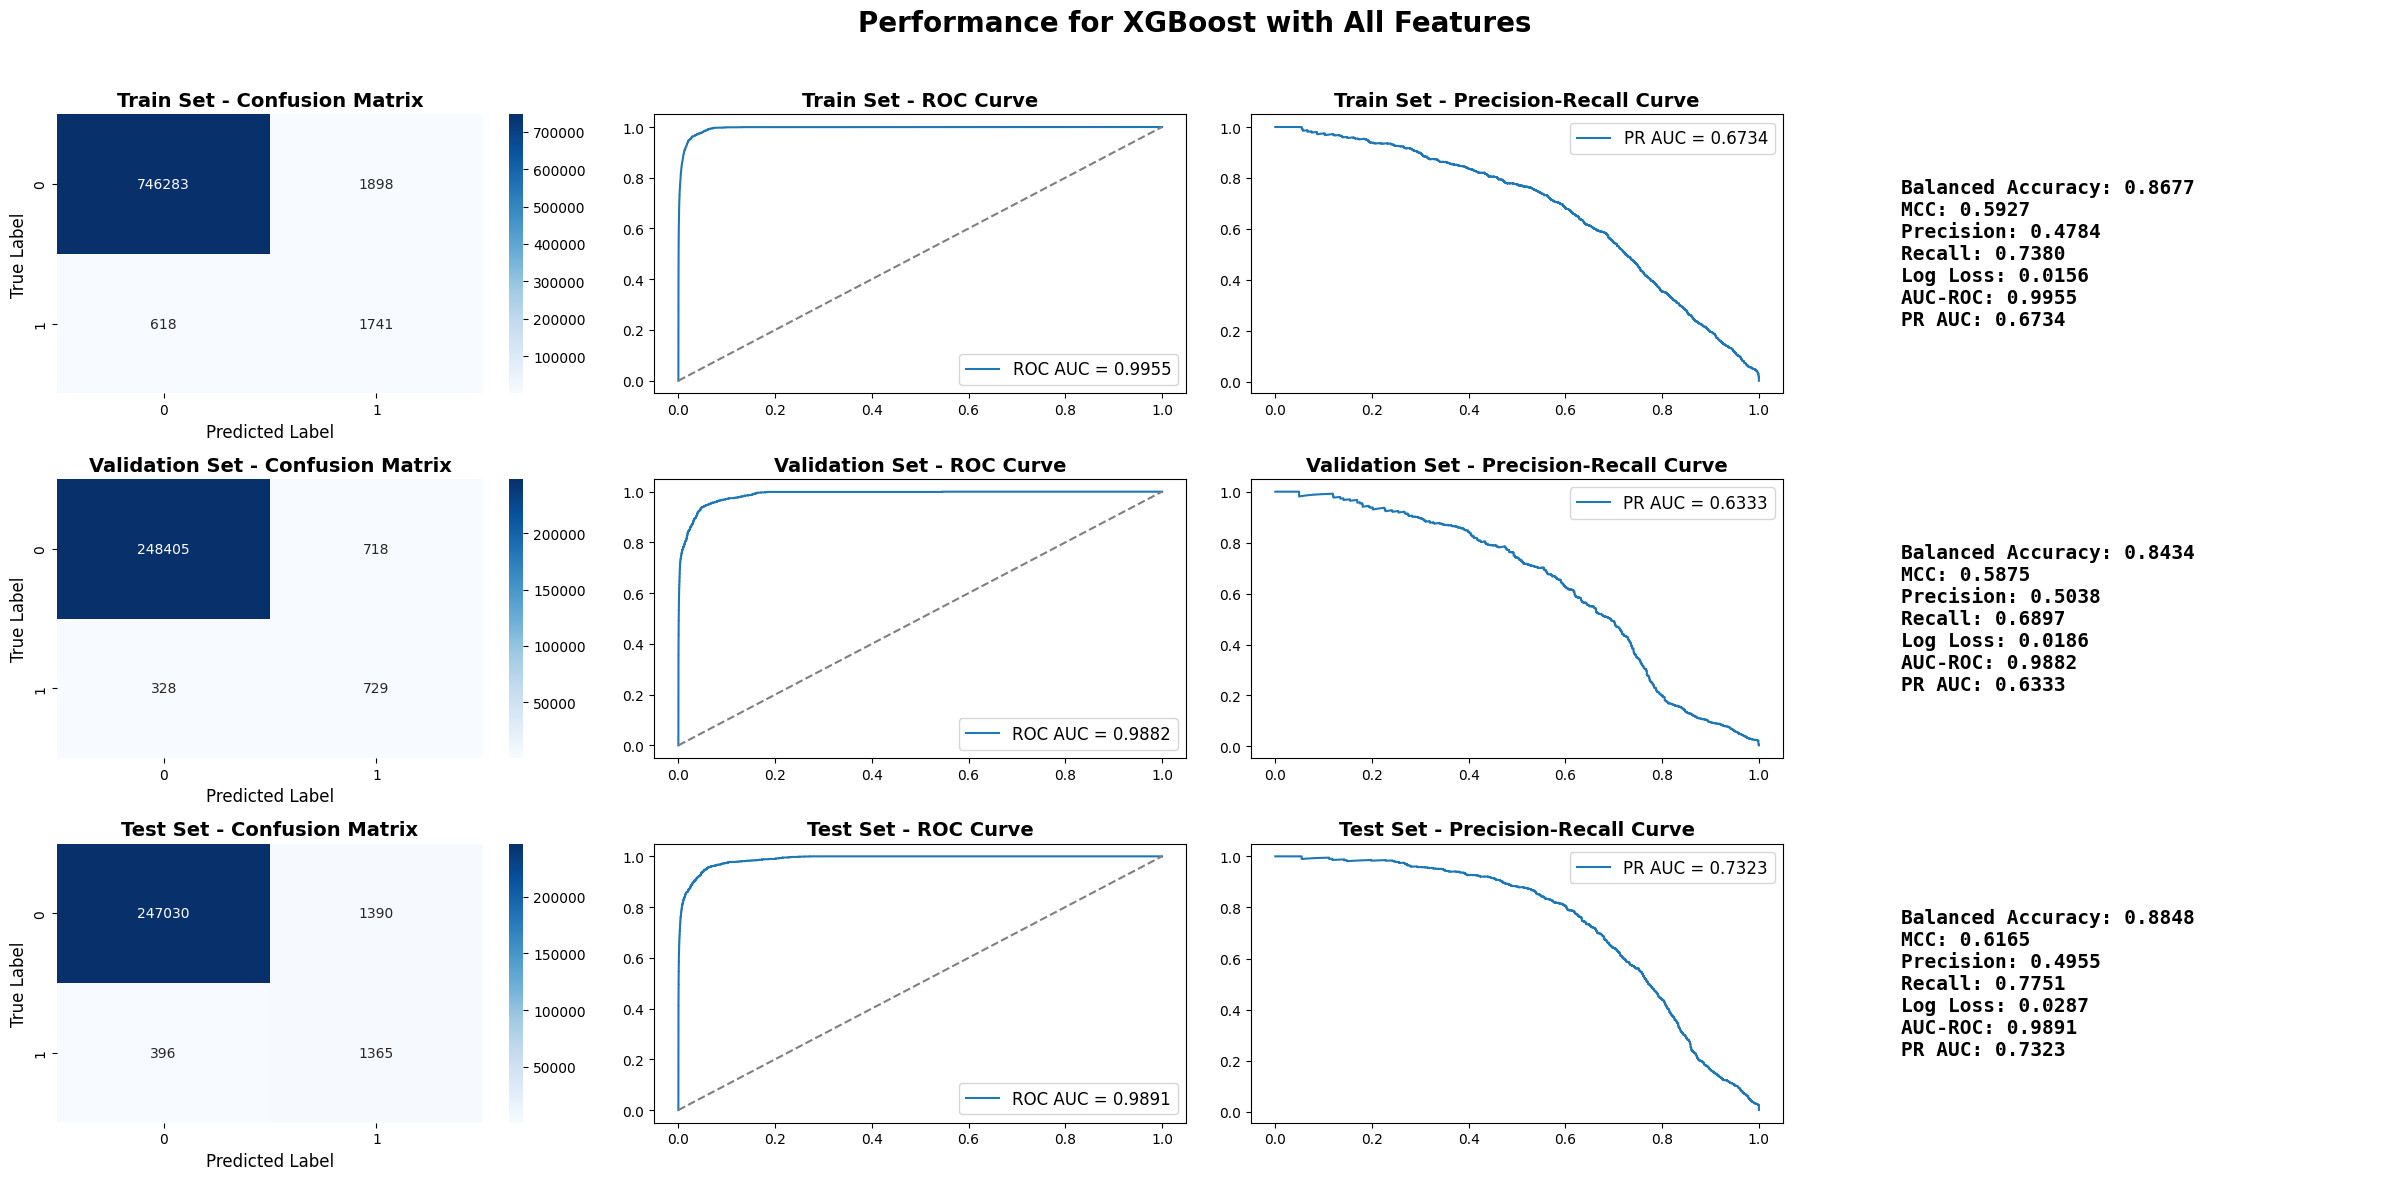

In [ ]:
# Fit final XGB model on the reduced feature set:
final_model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=20,
    max_depth=4,              # still shallow to avoid overfitting
    learning_rate=0.05,       # lower for smoother convergence
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,            # lighter L1
    reg_lambda=1.0,           # keep some L2
    min_child_weight=2,       # allow smaller splits
    gamma=0.5,                # still some split penalty
    scale_pos_weight=12,
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42
)

final_model.fit(X_train[selected_features], pl.y_train,
                eval_set=[(X_val[selected_features], pl.y_val)],
                verbose=False)

# Evaluate on test set:
y_test_prob = final_model.predict_proba(X_test[selected_features])[:, 1]
y_test_pred = (y_test_prob > 0.5).astype(int)
test_pr_auc = average_precision_score(pl.y_test, y_test_prob)
print(f"Final test PR-AUC = {test_pr_auc:.4f}")

result_metrics(
    slide_title,
    pl.y_train, train_pred, train_proba,
    pl.y_val,   val_pred,   val_proba,
    pl.y_test,  y_test_pred,  y_test_prob,
    class_labels=["Licit", "Illicit"]
)

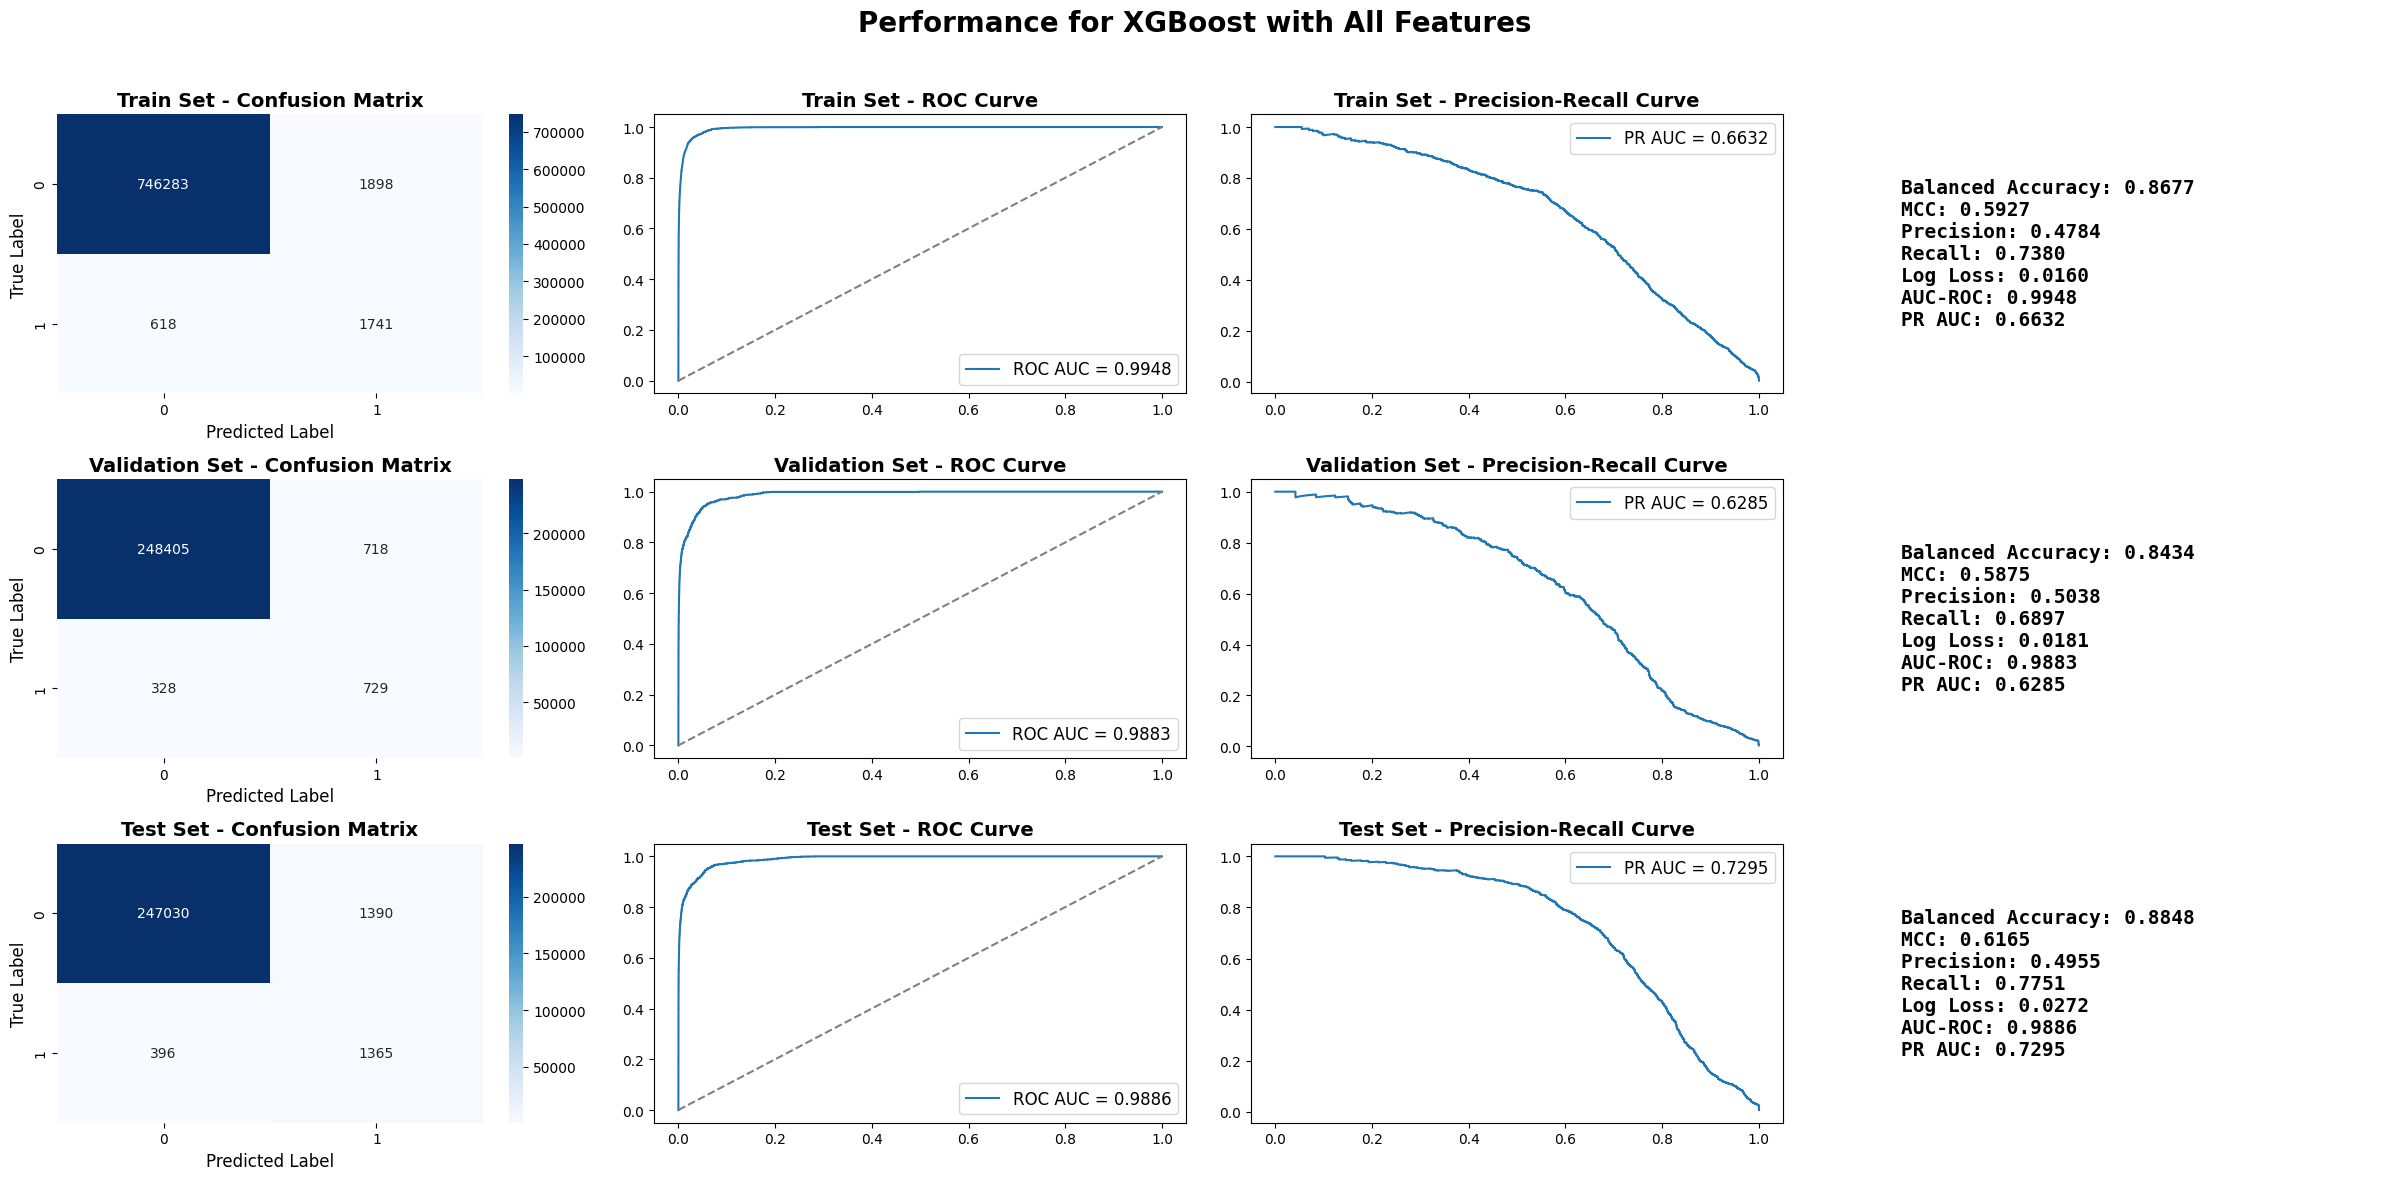

In [53]:
# 3) Get predicted probabilities:
y_train_proba = final_model.predict_proba(X_train[selected_features])[:, 1]
y_val_proba   = final_model.predict_proba(X_val[selected_features])[:, 1]
y_test_proba  = final_model.predict_proba(X_test[selected_features])[:, 1]

# 4) Apply 0.5 threshold for binary predictions:
y_train_pred = (train_proba > 0.5).astype(int)
y_val_pred   = (val_proba   > 0.5).astype(int)
y_test_pred  = (test_proba  > 0.5).astype(int)
result_metrics(
    slide_title,
    pl.y_train, y_train_pred, y_train_proba,
    pl.y_val,   y_val_pred,   y_val_proba,
    pl.y_test,  y_test_pred,  y_test_prob,
    class_labels=["Licit", "Illicit"]
)